In [ ]:
!mkdir -p ../data/raw/
!curl -L https://huggingface.co/datasets/metalwhale/stock_data/resolve/main/us_data.zip -o ../data/raw/us_data.zip
!unzip ../data/raw/us_data.zip -d ../data/us_data

In [1]:
import glob
import os
from pathlib import Path

import pandas as pd

# Dow components (as of August 31, 2020). See: https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average
DOW_COMPANIES = [
    "AXP", "AMGN", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "DIS", "DOW",
    "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "MCD", "MMM", "MRK",
    "MSFT", "NKE", "PG", "CRM", "TRV", "UNH", "VZ", "V", "WBA", "WMT",
]


def read_data(pattern: str) -> pd.DataFrame:
    df = None
    for company_file_path in glob.glob(pattern):
        symbol = Path(company_file_path).stem
        if symbol not in DOW_COMPANIES:
            os.remove(company_file_path)
            continue
        if symbol in ["CRM", "DOW", "V"]:  # These companies don't have much data
            continue
        company_df = pd.read_csv(company_file_path)\
            .filter(items=["date", "close", "volume"])\
            .rename(columns={"close": f"{symbol}_close", "volume": f"{symbol}_volume"})
        company_df = company_df.set_index(["date"])
        company_df.index = pd.to_datetime(company_df.index, utc=True, format="mixed").strftime("%Y-%m-%d")
        if df is None:
            df = company_df
        else:
            df = df.join(company_df, how="inner")
    df.index = pd.to_datetime(df.index)
    df.columns = pd.MultiIndex.from_tuples(
        [tuple(c.split("_")) for c in df.columns.values],
        names=["asset", "channels"],
    )
    return df


df = read_data("../data/us_data/*.csv")
n_assets = len(df.columns.levels[0])
n_channels = len(df.columns.levels[1])

In [2]:
from typing import Tuple

import torch
from deepdow.data import InRAMDataset, RigidDataLoader, Noise
from deepdow.utils import raw_to_Xy


def generate_dataloaders(df: pd.DataFrame, lookback: int, gap: int, horizon: int) -> Tuple[torch.utils.data.DataLoader]:
    X, timestamps, y, asset_names, _indicators = raw_to_Xy(df, lookback=lookback, gap=gap, freq="B", horizon=horizon)
    n_samples = X.shape[0]
    test_amount = 200
    val_ratio = 0.1
    indices_test = list(range(n_samples))[-test_amount:]
    indices_val = list(range(0, n_samples - test_amount, int(1 / val_ratio)))
    indices_train = [i for i in list(range(n_samples - test_amount)) if i not in indices_val]
    print(indices_train)
    print(indices_val)
    print(indices_test)
    dataset_train = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names, transform=Noise())
    dataset_holdout = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names)
    batch_size = 32
    dataloader_train = RigidDataLoader(dataset_train, indices=indices_train, batch_size=batch_size)
    dataloader_val = RigidDataLoader(dataset_holdout, indices=indices_val, batch_size=batch_size)
    dataloader_test = RigidDataLoader(dataset_holdout, indices=indices_test, batch_size=batch_size)
    return dataloader_train, dataloader_val, dataloader_test


lookback, gap, horizon = 20, 2, 5
torch.manual_seed(1)
dataloader_train, dataloader_val, dataloader_test = generate_dataloaders(df, lookback, gap, horizon)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 231, 232, 233, 234, 235, 236, 237, 238, 239, 241, 242, 243, 244

In [3]:
from deepdow.nn import KeynesNet


def build_network(n_channels: int) -> torch.nn.Module:
    network = KeynesNet(n_channels)
    network.train()
    return network


network = build_network(n_channels)
print(network)

KeynesNet(
  (transform_layer): RNN(
    (cell): LSTM(2, 32)
  )
  (norm_layer_1): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (norm_layer_2): GroupNorm(4, 32, eps=1e-05, affine=True)
  (time_collapse_layer): AverageCollapse()
  (channel_collapse_layer): AverageCollapse()
  (portfolio_opt_layer): SoftmaxAllocator(
    (layer): Softmax(dim=1)
  )
)


In [4]:
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.experiments import Run
from deepdow.losses import MaximumDrawdown, MeanReturns, SharpeRatio


def train_network(network: torch.nn.Module, dataloader_train: torch.utils.data.DataLoader, dataloader_val: torch.utils.data.DataLoader):
    run = Run(
        network,
        MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio(),
        dataloader_train,
        val_dataloaders={"val": dataloader_val},
        optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
        callbacks=[EarlyStoppingCallback(metric_name="loss", dataloader_name="val", patience=25)],
    )
    run.launch(1000)


train_network(network, dataloader_train, dataloader_val)

Epoch 219: 100%|██████████| 172/172 [00:10<00:00, 16.32it/s, loss=-0.35526, val_loss=-0.32303]


Training interrupted
Training stopped early because there was no improvement in val_loss for 25 epochs


metric      benchmark
MaxDD       @1overN       2.440673
            @random       2.447974
            network       2.799722
MeanReturn  @1overN      -0.164423
            @random      -0.162562
            network      -0.369956
Sharpe      @1overN     -17.629375
            @random     -15.647655
            network     -52.203045
Name: value, dtype: float32


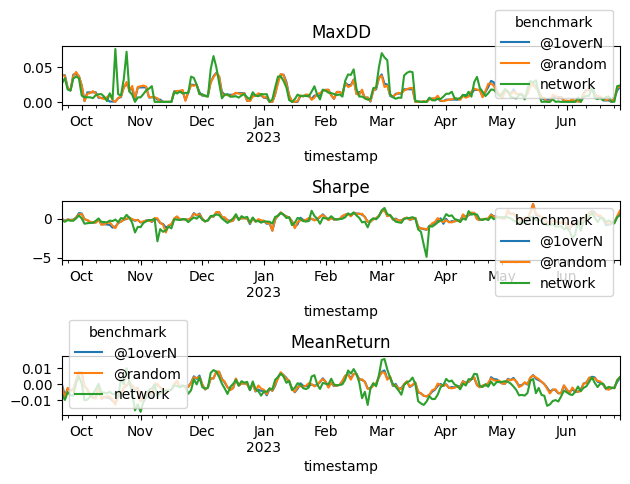

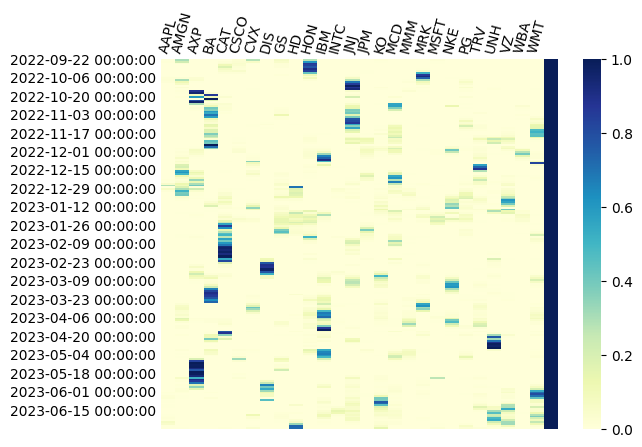

In [5]:
import matplotlib.pyplot as plt
from deepdow.benchmarks import OneOverN, Random
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap


def eval_network(network: torch.nn.Module, dataloader_test: torch.utils.data.DataLoader):
    network = network.eval()
    benchmarks = {
        "@1overN": OneOverN(),
        "@random": Random(),
        "network": network,
    }
    metrics = {
        "MaxDD": MaximumDrawdown(),
        "Sharpe": SharpeRatio(),
        "MeanReturn": MeanReturns(),
    }
    metrics_table = generate_metrics_table(benchmarks, dataloader_test, metrics)
    print(metrics_table.groupby(["metric", "benchmark"])["value"].sum())
    plot_metrics(metrics_table)
    plt.show()
    weight_table = generate_weights_table(network, dataloader_test)
    plot_weight_heatmap(weight_table, add_sum_column=True, time_format=None, time_skips=10)
    plt.show()


eval_network(network, dataloader_test)